# CNN Modelling Using SMOTE and SMOTENC


In [1]:
import os
import math
import numpy as np
import pandas as pd

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt


# !pip install catboost
from catboost import CatBoostClassifier, Pool

In [26]:
# from google.colab import drive
# drive.mount('/content/drive')

# main_dir = '/content/drive/MyDrive/SKKU_study/01_Final_assignment'
# data_dir = os.path.join(main_dir, 'data')
# processed_data_dir = os.path.join(data_dir, 'processed')
# raw_data_dir = os.path.join(data_dir, 'raw')

# os.makedirs(data_dir, exist_ok=True)
# os.makedirs(processed_data_dir, exist_ok=True)

# train = pd.read_csv(os.path.join(processed_data_dir, 'train.csv'))
# test = pd.read_csv(os.path.join(processed_data_dir, 'test.csv'))
# raw = pd.read_csv(os.path.join(raw_data_dir, 'credit_score_data.csv'))

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
raw = pd.read_csv('./processed.csv')

target = 'Credit_Score'
train.shape, test.shape

x_train = train.drop(target,axis=1)
y_train = train[target]
x_test = test.drop(target,axis=1)
y_test = test[target]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((75000, 22), (75000,), (25000, 22), (25000,))

In [29]:
from sklearn.preprocessing import RobustScaler

def make_scaled(train, data):
  """
  :train: train 데이터 입력 필요. 트레인 데이터 기반으로 test 스케일링 진행
  :param data: processed 데이터 입력
  :return: 스케일된 데이터 프레임 출력
  """

  rs = RobustScaler()

  scaling_cols = ['Monthly_Inhand_Salary', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month',
                  'Amount_invested_monthly', 'Monthly_Balance']
  rs.fit(train[scaling_cols])
  rs_data = rs.transform(data.loc[:, scaling_cols])
  data[scaling_cols] = rs_data

  return data

In [30]:
x_train = make_scaled(x_train, x_train)
x_test = make_scaled(x_train, x_test)

In [31]:
x_train

,Customer_ID,Month,Age,Occupation,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,576,1,3,12,-0.407299,3.0,4.0,3.0,0,3.0,...,4.0,2,-0.279953,-0.648697,1,1,-0.139504,-0.546677,2,-0.108344
1,576,2,3,12,-0.407299,3.0,4.0,3.0,0,3.0,...,4.0,2,-0.279953,-0.041010,1,1,-0.139504,-0.546677,3,-0.250764
2,576,3,3,12,-0.407299,3.0,4.0,3.0,0,3.0,...,4.0,2,-0.279953,-0.436728,1,1,-0.139504,-0.546677,4,-0.012686
3,576,4,3,12,-0.407299,3.0,4.0,3.0,0,5.0,...,4.0,2,-0.279953,-0.108287,1,1,-0.139504,-0.546677,5,-0.563450
4,576,5,3,12,-0.407299,3.0,4.0,3.0,0,6.0,...,4.0,2,-0.279953,-0.888964,1,1,-0.139504,-0.546677,1,0.039852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,9254,2,3,9,0.062676,4.0,6.0,7.0,0,23.0,...,3.0,2,-0.577496,-0.374315,1,1,-0.264438,-0.487533,4,0.339440
74996,9254,3,3,9,0.062676,4.0,6.0,7.0,0,20.0,...,3.0,2,-0.577496,0.834349,1,1,-0.264438,-0.487533,1,0.391326
74997,9254,4,3,9,0.062676,4.0,6.0,7.0,0,23.0,...,3.0,2,-0.577496,0.281512,1,1,-0.264438,-0.487533,0,0.747110
74998,9254,5,3,9,0.062676,4.0,6.0,7.0,0,18.0,...,3.0,2,-0.577496,0.981701,1,1,-0.264438,-0.487533,1,0.832901


## baseline

In [32]:
from imblearn.over_sampling import SMOTE

def sampling_smote_baseline(x_input_df, y_input_df, sampling_strategy='auto'):
  """
  smote기법을 처리 없이 시도하는 함수

  params:
    x_input_df: 샘플링 원하는 x데이터프레임
    y_input_df: 샘플링 원하는 y데이터프레임
    sampling_strategy: oversampling class 비율 설정
      default='auto' 자동으로 minority의 수를 majority의 수와 맞춤
      otherwise, 딕셔너리 형태로 주어야함 (e.g. {0: 1.2, 1: 0.5, 2: 1.9})

  return :
    샘플링 완료된 x, y 데이터프레임

  사용예시 :
    output_x, output_y = sampling_smote_vanilla(x_train,y_train)


  참고:
  https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
  """


  #sampling fit
  smote_clf = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
  x_sampling_df, y_sampling_df = smote_clf.fit_resample(x_input_df, y_input_df)
  '''
  sampling_strategy : default='auto'

  'minority': 소수 클래스만 리샘플링합니다.
  'not minority': 소수 클래스를 제외한 모든 클래스를 다시 샘플링합니다.
  'not majority': 대부분의 클래스를 제외한 모든 클래스를 리샘플링합니다.
  'all': 모든 클래스를 다시 샘플링합니다.
  'auto': 에 해당합니다 .'not majority'


  k_neighbors int 또는 객체, 기본값=5
  샘플을 구성하는 데 사용할 가장 가까운 이웃의 수
  '''

  # result print
  print('=========== shape ===========')
  print('before shape : ', x_input_df.shape, y_input_df.shape)
  print('after shape : ', x_sampling_df.shape, y_sampling_df.shape)

  print('\n\n=========== value_counts ===========')
  print('before shape : ', dict(y_input_df.value_counts()))
  print('after shape : ', dict(y_sampling_df.value_counts()))

  #result return
  return x_sampling_df, y_sampling_df

In [33]:
bsmote_x, bsmote_y = sampling_smote_baseline(x_train, y_train)

=========== shape ===========
before shape :  (75000, 22) (75000,)
after shape :  (120642, 22) (120642,)


=========== value_counts ===========
before shape :  {1: 40214, 0: 21782, 2: 13004}
after shape :  {2: 40214, 1: 40214, 0: 40214}


In [5]:
bsmote_x

,Customer_ID,Month,Age,Occupation,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,576,1,3,12,7.509249,3.00000,4.000000,3.000000,0,3.000000,...,4.000000,2,28.460148,26.822620,1,1,49.574949,21.465380,2,312.494089
1,576,2,3,12,7.509249,3.00000,4.000000,3.000000,0,3.000000,...,4.000000,2,28.460148,31.944960,1,1,49.574949,21.465380,3,284.629162
2,576,3,3,12,7.509249,3.00000,4.000000,3.000000,0,3.000000,...,4.000000,2,28.460148,28.609352,1,1,49.574949,21.465380,4,331.209863
3,576,4,3,12,7.509249,3.00000,4.000000,3.000000,0,5.000000,...,4.000000,2,28.460148,31.377862,1,1,49.574949,21.465380,5,223.451310
4,576,5,3,12,7.509249,3.00000,4.000000,3.000000,0,6.000000,...,4.000000,2,28.460148,24.797347,1,1,49.574949,21.465380,1,341.489231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120637,3933,2,5,13,6.823428,5.00000,3.000000,5.000000,0,20.000000,...,2.000000,2,18.122086,29.388490,1,1,0.000000,12.680046,3,318.697549
120638,3455,5,3,12,8.878082,2.00000,3.112734,7.028184,0,7.197285,...,4.000000,2,21.922314,29.127050,1,1,160.321072,135.648934,2,456.434967
120639,4671,5,3,10,8.130636,3.80227,2.197730,7.802270,0,0.798486,...,3.201514,2,23.302351,26.421221,1,1,33.496335,46.333980,2,440.347491
120640,875,3,3,7,8.102804,2.00000,3.354364,4.076060,0,11.771820,...,2.000000,2,24.177354,38.874059,1,1,48.799456,28.582642,0,492.979918


In [34]:
sample_size = bsmote_x.shape[0]
num_features = bsmote_x.shape[1]
input_dim = 1 # each feature is represented by 1 number

print('Before Reshaping... :')
print(bsmote_x.shape)
print(x_test.shape)
print('\n')

x_train_reshape = np.reshape(bsmote_x.values, newshape=(sample_size, num_features, input_dim))
x_test_reshape = np.reshape(x_test.values, newshape=(x_test.shape[0], num_features, input_dim))

print('After Reshaping... : ')
print(x_train_reshape.shape)
print(x_test_reshape.shape)

Before Reshaping... :
(120642, 22)
(25000, 22)


After Reshaping... : 
(120642, 22, 1)
(25000, 22, 1)


In [35]:
import tensorflow as tf
from time import time
from datetime import timedelta
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# loss와 accuracy 시각화를 위한 함수 정의
def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], 'b-', label='loss')
    plt.plot(history.history['val_loss'], 'g--', label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Val Loss')
    plt.legend()
    plt.show()

def plot_acc(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['acc'], 'b-', label='acc')
    plt.plot(history.history['val_acc'], 'g--', label='val_acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Val Accuracy')
    plt.legend()
    plt.show()

In [38]:
# 결과 재활용을 위한 시드 설정 함수 정의
import random
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    # When running on the CuDNN backend, two further options must be set
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [39]:
# 분류모델 결과 평가를 위한 혼동행렬 리포트 & 시각화 함수 정의
def clf_report_plot(y_true, X_test, model):

    result = model.predict(X_test)

    y_pred = []
    for pred in result:
        y_pred.append(np.argmax(pred))

    print(classification_report(y_true, y_pred, digits=4))

    # plt.rc('font', family='NanumGothicOTF') # For MacOS
    plt.rc('font', family='NanumGothic') # For Windows

    ax = plt.subplot()
    ax.figure.set_size_inches(10, 10)
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', ax=ax)

    ax.set_title('Confusion Matrix',fontsize=20, y=1.05)
    ax.set_xlabel('Predicted Labels', fontsize=15)
    ax.set_ylabel('True Labels', fontsize=15)

    ax.xaxis.set_ticklabels(['Poor', 'Standard', 'Good'])
    ax.yaxis.set_ticklabels(['Poor', 'Standard', 'Good'])
    plt.show()

In [40]:
from tensorflow.keras.models import Sequential, load_model, Model

from tensorflow.keras.layers import Dense, LSTM, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Input

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report

In [41]:
import os

In [42]:
num_classes = 3

In [53]:
set_seed(42)
model = Sequential()
model.add(Input(shape=(num_features, input_dim)))
model.add(Conv1D(128, kernel_size=2, activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides=1))
model.add(Dropout(0.5))
model.add(Conv1D(128, kernel_size=4, activation='relu'))

model.add(Dropout(0.5))
model.add(Conv1D(128, kernel_size=8, activation='relu'))
# model.add(Conv1D(64, kernel_size=4, strides=4, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(num_classes, activation='softmax'))

Random seed set as 42


In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 21, 128)           384       
                                                                 
 dropout_4 (Dropout)         (None, 21, 128)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 18, 128)           65664     
                                                                 
 dropout_5 (Dropout)         (None, 18, 128)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 11, 128)           131200    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                      

In [55]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('oversampled_cnn_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [56]:
print('Algorithm starts learning.....')
start_time = time()

history = model.fit(x_train_reshape, bsmote_y, epochs=50, batch_size=64, validation_split=0.2, callbacks=[es, mc])

print("Learning Durations: ", timedelta(seconds=(time() - start_time)))

Algorithm starts learning.....
Epoch 1/50


2022-11-18 19:48:12.138656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1509/1509 [==============================] - ETA: 0s - loss: 1.2557 - acc: 0.4775

2022-11-18 19:48:32.686884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_acc improved from -inf to 0.00000, saving model to oversampled_cnn_best_model.h5
1509/1509 [==============================] - 23s 15ms/step - loss: 1.2557 - acc: 0.4775 - val_loss: 1.5280 - val_acc: 0.0000e+00
Epoch 2/50
1508/1509 [============================>.] - ETA: 0s - loss: 0.9092 - acc: 0.5700
Epoch 2: val_acc did not improve from 0.00000
1509/1509 [==============================] - 21s 14ms/step - loss: 0.9092 - acc: 0.5700 - val_loss: 1.4952 - val_acc: 0.0000e+00
Epoch 3/50
1507/1509 [============================>.] - ETA: 0s - loss: 0.8662 - acc: 0.5970
Epoch 3: val_acc did not improve from 0.00000
1509/1509 [==============================] - 21s 14ms/step - loss: 0.8662 - acc: 0.5969 - val_loss: 1.3647 - val_acc: 0.0000e+00
Epoch 4/50
1507/1509 [============================>.] - ETA: 0s - loss: 0.8427 - acc: 0.6115
Epoch 4: val_acc did not improve from 0.00000
1509/1509 [==============================] - 21s 14ms/step - loss: 0.8428 - acc: 0.6114 - val_loss: 1

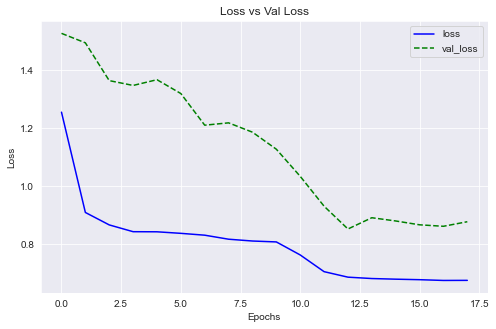

In [57]:
plot_loss(history)

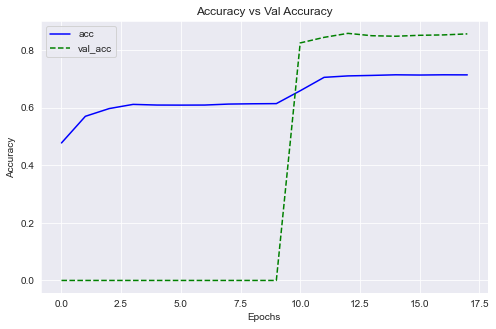

In [58]:
plot_acc(history)

In [59]:
best_model = load_model('./oversampled_cnn_best_model.h5')
print('Test Accuracy: {}'.format(best_model.evaluate(x_test_reshape, y_test)[1]))

2022-11-18 19:54:13.809987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 5s 6ms/step - loss: 1.0850 - acc: 0.3522
Test Accuracy: 0.3521600365638733


In [60]:
print("Train Accuracy: {}".format(best_model.evaluate(x_train_reshape, bsmote_y)[1]))

3771/3771 [==============================] - 21s 5ms/step - loss: 0.7045 - acc: 0.7514
Train Accuracy: 0.7514050006866455


 79/782 [==>...........................] - ETA: 1s

2022-11-18 19:54:39.051373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 2s 2ms/step


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


              precision    recall  f1-score   support

           0     0.7213    0.0793    0.1428      7216
           1     0.5108    0.3561    0.4197     12960
           2     0.2384    0.7498    0.3618      4824

    accuracy                         0.3522     25000
   macro avg     0.4902    0.3951    0.3081     25000
weighted avg     0.5190    0.3522    0.3286     25000



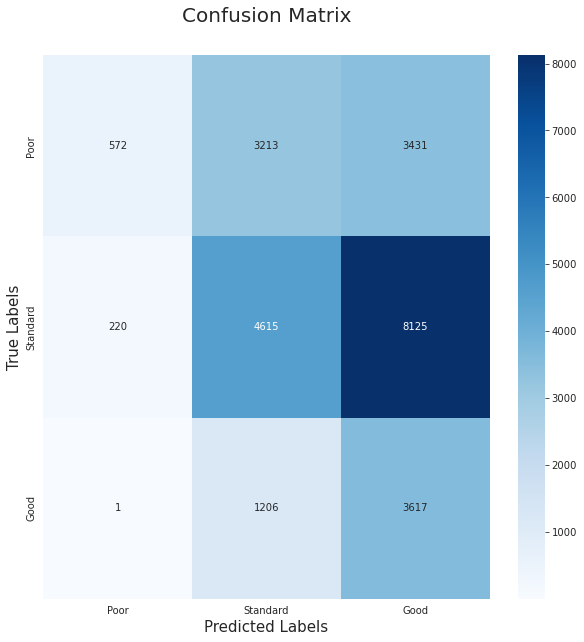

In [61]:
clf_report_plot(y_test, x_test_reshape, best_model)

In [52]:
x_train_reshape.shape
bsmote_y.shape

(120642,)

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
rf = RandomForestClassifier(random_state=42)

In [64]:
rf.fit(bsmote_x, bsmote_y)

RandomForestClassifier(random_state=42)

In [66]:
rf.score(x_train, y_train)

1.0

In [67]:
rf.score(x_test, y_test)

0.52088

In [17]:
# strategy 활용 예시
# 일부만 오버샘플링
strategy = {0: 30000, 1: 40214, 2: 25000}
output_x,output_y = sampling_smote_baseline(x_train,y_train, strategy)

=========== shape ===========
before shape :  (75000, 22) (75000,)
after shape :  (95214, 22) (95214,)


=========== value_counts ===========
before shape :  {1: 40214, 0: 21782, 2: 13004}
after shape :  {1: 40214, 0: 30000, 2: 25000}


## SMOTENC

In [80]:
from imblearn.over_sampling import SMOTENC

def sampling_smote_enc(x_input_df, y_input_df, categorical_cols, sampling_strategy='auto'):
  """
  smote기법을 처리 없이 시도하는 함수

  params:
    x_input_df: 샘플링 원하는 x데이터프레임
    y_input_df: 샘플링 원하는 y데이터프레임

  return :
    샘플링 완료된 x, y 데이터프레임

  사용예시 :
    output_x, output_y = sampling_smote(x_train,y_train)

  참고:
  https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html
  """

  #sampling fit
  smote_clf = SMOTENC(random_state=42, categorical_features=categorical_cols, sampling_strategy=sampling_strategy)
  x_sampling_df, y_sampling_df = smote_clf.fit_resample(x_input_df, y_input_df)

  # result print
  print('=========== shape ===========')
  print('before shape : ',x_input_df.shape, y_input_df.shape)
  print('after shape : ',x_sampling_df.shape, y_sampling_df.shape)

  print('\n\n=========== value_counts ===========')
  print('before shape : ' ,dict(y_input_df.value_counts()))
  print('after shape : ',dict(y_sampling_df.value_counts()))

  #result return
  return x_sampling_df, y_sampling_df

In [81]:
cat_col = ['Customer_ID', 'Month', 'Credit_Mix', 'Credit_History_Age',
           'Payment_of_Min_Amount', 'Payment_Behaviour']

In [82]:
cat_col_idx = [list(raw.columns).index(col) for col in cat_col]
cat_col_idx

[0, 1, 12, 15, 16, 19]

In [83]:
smotenc_x, smotenc_y = sampling_smote_enc(x_train, y_train, cat_col_idx)

=========== shape ===========
before shape :  (75000, 22) (75000,)
after shape :  (120642, 22) (120642,)


=========== value_counts ===========
before shape :  {1: 40214, 0: 21782, 2: 13004}
after shape :  {2: 40214, 1: 40214, 0: 40214}


In [84]:
smotenc_x

,Customer_ID,Month,Age,Occupation,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,576,1,3,12,-0.407299,3.000000,4.000000,3.000000,0,3.000000,...,4.0,2,-0.279953,-0.648697,1,1,-0.139504,-0.546677,2,-0.108344
1,576,2,3,12,-0.407299,3.000000,4.000000,3.000000,0,3.000000,...,4.0,2,-0.279953,-0.041010,1,1,-0.139504,-0.546677,3,-0.250764
2,576,3,3,12,-0.407299,3.000000,4.000000,3.000000,0,3.000000,...,4.0,2,-0.279953,-0.436728,1,1,-0.139504,-0.546677,4,-0.012686
3,576,4,3,12,-0.407299,3.000000,4.000000,3.000000,0,5.000000,...,4.0,2,-0.279953,-0.108287,1,1,-0.139504,-0.546677,5,-0.563450
4,576,5,3,12,-0.407299,3.000000,4.000000,3.000000,0,6.000000,...,4.0,2,-0.279953,-0.888964,1,1,-0.139504,-0.546677,1,0.039852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120637,3933,6,5,13,-0.935455,5.000000,3.000000,5.000000,0,20.000000,...,2.0,2,-0.788696,-0.070272,1,1,-0.567506,-0.749400,3,-0.076638
120638,3453,5,3,12,0.648010,1.971816,3.000000,6.943633,0,6.943633,...,1.0,2,-0.601754,-0.537640,1,1,0.851301,2.123628,2,0.655492
120639,4674,6,5,11,0.048321,5.000000,1.000000,9.000000,0,0.399243,...,4.0,2,-0.475277,0.187690,1,1,-0.236810,-0.056576,4,0.291549
120640,896,4,3,8,0.149960,2.000000,1.000000,8.000000,0,1.569576,...,2.0,2,-1.230683,0.358909,1,1,0.006670,-0.384172,1,0.521573


In [86]:
sample_size = smotenc_x.shape[0]
num_features = smotenc_x.shape[1]
input_dim = 1  # each feature is represented by 1 number

print('Before Reshaping... :')
print(smotenc_x.shape)
print(x_test.shape)
print('\n')

x_train_reshape = np.reshape(smotenc_x.values, newshape=(sample_size, num_features, input_dim))
x_test_reshape = np.reshape(x_test.values, newshape=(x_test.shape[0], num_features, input_dim))

print('After Reshaping... : ')
print(x_train_reshape.shape)
print(x_test_reshape.shape)

Before Reshaping... :
(120642, 22)
(25000, 22)


After Reshaping... : 
(120642, 22, 1)
(25000, 22, 1)
Before Reshaping... :
(120642, 22)
(25000, 22)


After Reshaping... : 
(120642, 22, 1)
(25000, 22, 1)


In [87]:
set_seed(42)
model = Sequential()
model.add(Input(shape=(num_features, input_dim)))
model.add(Conv1D(128, kernel_size=2, activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides=1))
model.add(Dropout(0.5))
model.add(Conv1D(128, kernel_size=4, activation='relu'))

model.add(Dropout(0.5))
model.add(Conv1D(128, kernel_size=8, activation='relu'))
# model.add(Conv1D(64, kernel_size=4, strides=4, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(num_classes, activation='softmax'))

Random seed set as 42


In [88]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 21, 128)           384       
                                                                 
 dropout_8 (Dropout)         (None, 21, 128)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 18, 128)           65664     
                                                                 
 dropout_9 (Dropout)         (None, 18, 128)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 11, 128)           131200    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                      

In [89]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('smotenc_cnn_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [90]:
print('Algorithm starts learning.....')
start_time = time()

history = model.fit(x_train_reshape, smotenc_y, epochs=50, batch_size=64, validation_split=0.2, callbacks=[es, mc])

print("Learning Durations: ", timedelta(seconds=(time() - start_time)))

Algorithm starts learning.....
Epoch 1/50


2022-11-18 20:14:41.104761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1509/1509 [==============================] - ETA: 0s - loss: 1.2577 - acc: 0.4681

2022-11-18 20:14:59.027133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_acc improved from -inf to 0.00000, saving model to smotenc_cnn_best_model.h5
1509/1509 [==============================] - 20s 13ms/step - loss: 1.2577 - acc: 0.4681 - val_loss: 1.5986 - val_acc: 0.0000e+00
Epoch 2/50
1509/1509 [==============================] - ETA: 0s - loss: 0.9637 - acc: 0.5122
Epoch 2: val_acc did not improve from 0.00000
1509/1509 [==============================] - 20s 13ms/step - loss: 0.9637 - acc: 0.5122 - val_loss: 1.6316 - val_acc: 0.0000e+00
Epoch 3/50
1505/1509 [============================>.] - ETA: 0s - loss: 0.9542 - acc: 0.5152
Epoch 3: val_acc did not improve from 0.00000
1509/1509 [==============================] - 20s 13ms/step - loss: 0.9542 - acc: 0.5151 - val_loss: 1.5950 - val_acc: 0.0000e+00
Epoch 4/50
1508/1509 [============================>.] - ETA: 0s - loss: 0.9376 - acc: 0.5210
Epoch 4: val_acc did not improve from 0.00000
1509/1509 [==============================] - 20s 13ms/step - loss: 0.9376 - acc: 0.5210 - val_loss: 1.555

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


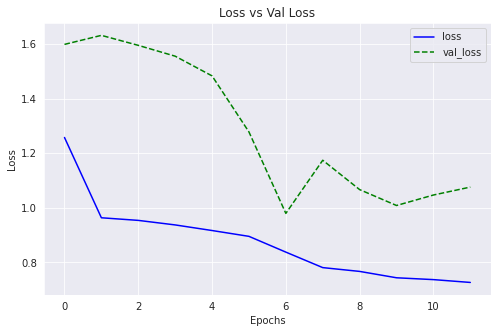

In [91]:
plot_loss(history)

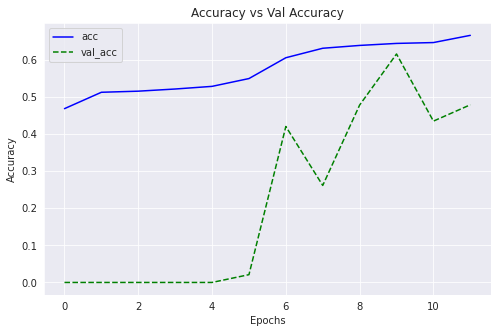

In [92]:
plot_acc(history)

In [93]:
best_model = load_model('./smotenc_cnn_best_model.h5')
print('Test Accuracy: {}'.format(best_model.evaluate(x_test_reshape, y_test)[1]))

 18/782 [..............................] - ETA: 4s - loss: 0.9453 - acc: 0.5278

2022-11-18 20:18:37.283656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 4s 5ms/step - loss: 0.9293 - acc: 0.5568
Test Accuracy: 0.5568000078201294


In [97]:
print("Train Accuracy: {}".format(best_model.evaluate(x_train_reshape, smotenc_y)[1]))

3771/3771 [==============================] - 24s 6ms/step - loss: 0.7469 - acc: 0.6922
Train Accuracy: 0.6921884417533875


 79/782 [==>...........................] - ETA: 1s

2022-11-18 20:19:02.109863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0     0.6132    0.3133    0.4147      7216
           1     0.5460    0.8931    0.6777     12960
           2     0.7391    0.0176    0.0344      4824

    accuracy                         0.5568     25000
   macro avg     0.6328    0.4080    0.3756     25000
weighted avg     0.6027    0.5568    0.4777     25000



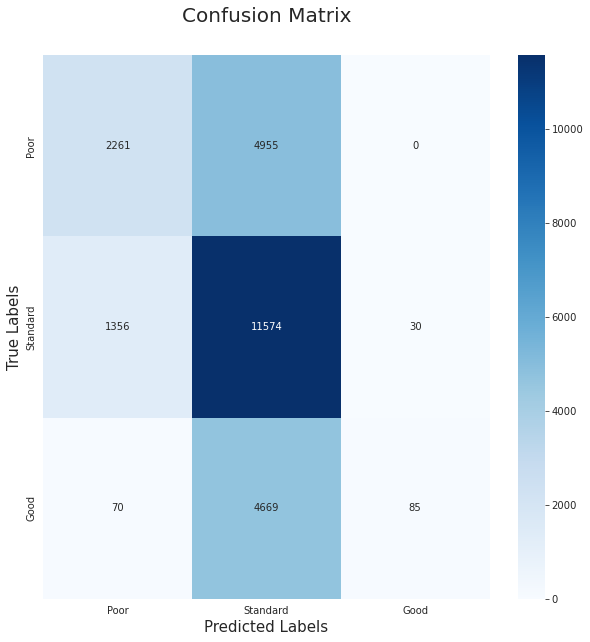

In [95]:
clf_report_plot(y_test, x_test_reshape, best_model)

약간 Random Forest의 방식처럼 반대의 경우로 성능이 좋은 친구와 ensemble하면 어떨까?

In [96]:
print('finished')

finished


In [98]:
rf = RandomForestClassifier(random_state=42)

In [99]:
rf.fit(smotenc_x, smotenc_y)

RandomForestClassifier(random_state=42)

In [100]:
rf.score(x_train, y_train)

0.9999733333333334

In [101]:
rf.score(x_test, y_test)

0.4742